# Neural Netwroks Graph
#

## First part : Spectral Graph Theory


In the first section of this TP, you will apply spectral filtering on a graph. A set of libraries that you might need is given in the following cell.

In [ ]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

 First, start by generating a graph (any kind) and extract its Laplacian. You may use the [networkx](https://networkx.org/) library to generate a random graph, or directly compute an adjacency matrix. The generated graph do not need to be too big, around 15 nodes should be okay. Remember that the Laplacian L is defined as : $L = D-A$

Also prepare the signal on you graph, by creating the H vector where one node is equal to 1, and the other ones are equal to 0

Finally, draw the graph you generated. To do so, you can use the [drawing](https://networkx.org/documentation/stable/reference/drawing.html) functions of networkx.

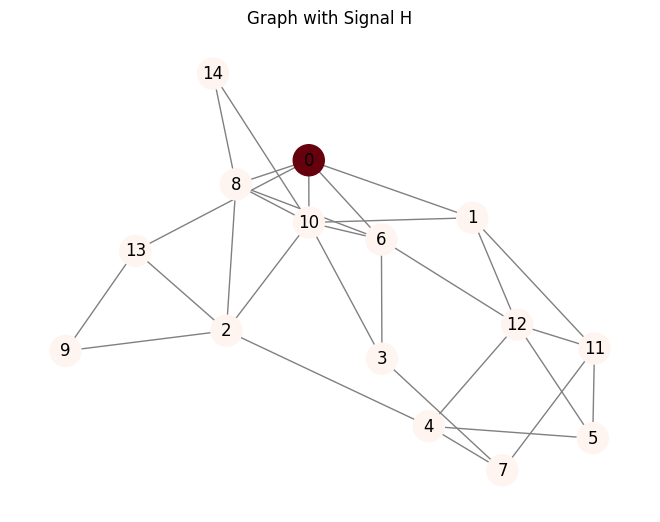

In [ ]:
# Generate a random graph with 15 nodes
G = nx.erdos_renyi_graph(15, p=0.3)

# Create signal vector H
H = np.zeros(15)
H[0] = 1  # Set the first node as active

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=H, cmap=plt.cm.Reds, node_size=500, edge_color='gray')
plt.title("Graph with Signal H")
plt.show()

Normalize your Laplacian, compute its eigen decomposition and verify that L = U.diag(lambda).u^T

Also plot every matrices (U, diag(lambda) and the Laplacian matrix)

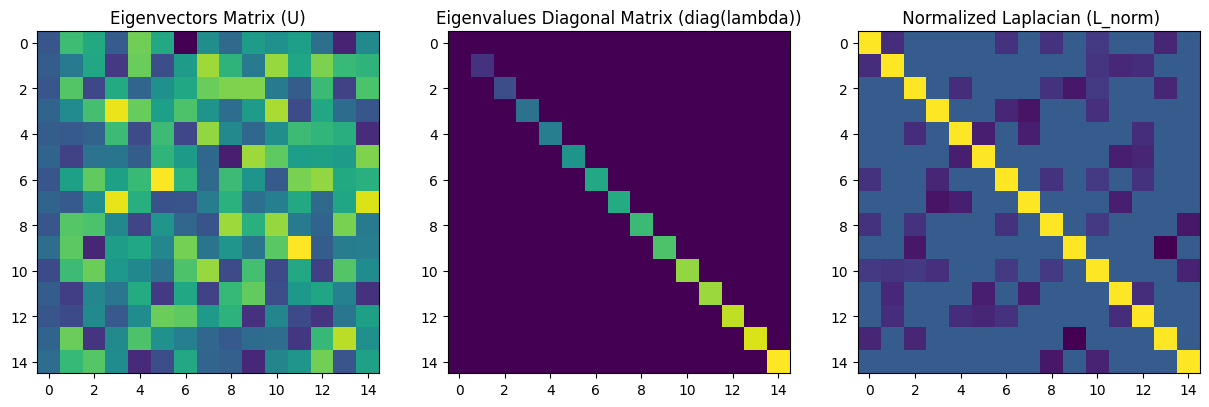

Verification L ≈ U diag(lambda) U^T: True


In [ ]:

# Compute the normalized Laplacian matrix
A = nx.adjacency_matrix(G).toarray()
D = np.diag(A.sum(axis=1))
D_inv_sqrt = np.diag( 1/np.sqrt(A.sum(axis=1)))
L = D - A
L_norm = D_inv_sqrt @ L @ D_inv_sqrt

# Eigen decomposition
eigvals, eigvecs = np.linalg.eigh(L_norm)

# Verify L = U diag(lambda) U^T
L_reconstructed = eigvecs @ np.diag(eigvals) @ eigvecs.T

# Plot matrices
fig, axes = plt.subplots(1,3,figsize=(15, 5))
axes[0].imshow(eigvecs)
axes[0].set_title("Eigenvectors Matrix (U)")
axes[1].imshow(np.diag(eigvals))
axes[1].set_title("Eigenvalues Diagonal Matrix (diag(lambda))")
axes[2].imshow(L_norm)
axes[2].set_title(" Normalized Laplacian (L_norm)")
plt.show()

# Verification of equality
print("Verification L ≈ U diag(lambda) U^T:", np.allclose(L_norm, L_reconstructed))


Now filter the eigen value with a low-pass filter, a band-pass filter and a high-pass filter. If you're not sure how to do it, since the eigen values are sorted by ascending order, you may only keep the first ones to produce a low-pass filter, the last ones for an high-pass filter and the middle ones for a band-pass filter.

Finally, plot your graph once again by using the drawing functions of networkx, and make appears the signal on the graph for each filtered signal (with the help of the node_color argument for example). You may also use the [nx_agraph.graphviz_layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_agraph.graphviz_layout.html) in order to fix the position of your nodes (and thus to have the same plot for each filtered graph).

Explain what you observe.

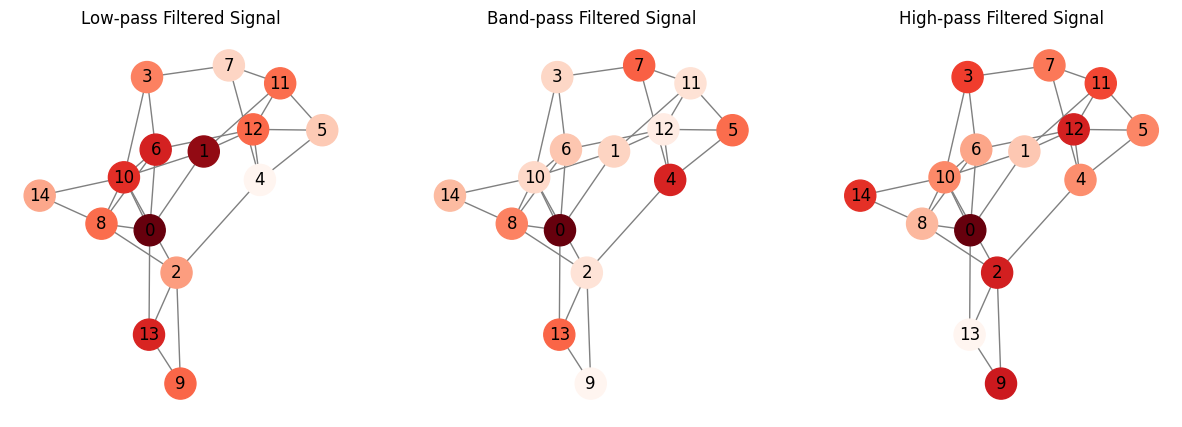

In [ ]:
# Apply filters
def apply_filter(eigvals, eigvecs, H, mode):
    if mode == "low":
        k = 5  # Keep lowest 5 eigenvalues
        return eigvecs[:, :k] @ eigvecs[:, :k].T @ H
    elif mode == "high":
        k = 5  # Keep highest 5 eigenvalues
        return eigvecs[:, -k:] @ eigvecs[:, -k:].T @ H
    elif mode == "band":
        k = 5  # Keep middle 5 eigenvalues
        mid = len(eigvals) // 2
        return eigvecs[:, mid-k//2:mid+k//2] @ eigvecs[:, mid-k//2:mid+k//2].T @ H

H_low = apply_filter(eigvals, eigvecs, H, "low")
H_high = apply_filter(eigvals, eigvecs, H, "high")
H_band = apply_filter(eigvals, eigvecs, H, "band")

# Fix node positions
pos = nx.spring_layout(G)

# Plot graphs with filtered signals
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Low-pass", "Band-pass", "High-pass"]
filtered_signals = [H_low, H_band, H_high]

for ax, H_filt, title in zip(axes, filtered_signals, titles):
    nx.draw(G, pos, with_labels=True, node_color=H_filt, cmap=plt.cm.Reds, node_size=500, edge_color='gray', ax=ax)
    ax.set_title(f"{title} Filtered Signal")

plt.show()


## Second part : Graph Neural Network

In the second part of the TP, you will code you own GNN an apply them on a toy example, the image seen in course. The code that allow to load the image and transform it into a graph is provided to you by the following code. You may find the images on Moodle.

In [ ]:
from PIL import Image
import numpy as np
def from_image_to_graph(path_image):
    image = Image.open(path_image)
    im = np.asarray(image)
    row, col = np.shape(im)
    adjacency = np.zeros((row*col, row*col))
    for i in range(row):
        for j in range(col):
            if i > 0:
                if j > 0:
                    adjacency[i * row + j, (i - 1) * row + j - 1] = 1
                adjacency[i * row + j, (i - 1) * row + j] = 1
                if j < col-1:
                    adjacency[i * row + j, (i - 1) * row + j + 1] = 1
            if j > 0 :
                adjacency[i * row + j, i * row + j - 1] = 1
            if j < col-1:
                adjacency[i * row + j, i * row + j + 1] = 1
            if i < row-1 :
                if j > 0:
                    adjacency[i * row + j, (i + 1) * row + j - 1] = 1
                adjacency[i * row + j, (i + 1) * row + j] = 1
                if j < col-1:
                    adjacency[i * row + j, (i + 1) * row + j + 1] = 1
    nodes = []
    for i in range(row):
        nodes = np.concatenate((nodes, im[i,:]))
    nodes = nodes/255

    return nodes, adjacency


You are now going to compute your own Graph Neural Network. For Deep Learning, you may find 2 different libraries in Python : [TensorFlow](https://www.tensorflow.org/?hl=fr) and [PyTorch](https://pytorch.org/). Both of them are based on tensors operations. In general, PyTorch is a little bit simpler to use, and it is probably the most used library between the two of them, mostly in reasearch and development, while TensorFlow is more efficient and scalable but is more demanding in terms of programming. For this TP, you may use either TensorFlow and PyTorch with PyTorch being recommanded. The instructions and advices given in the rest of the TP are mostly designed for PyTorch, but both are pretty similar. Also, for Graph Neural Networks, there is [PyTorch-Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), but it requires to know PyTorch first.

Whatever your choice, develop you own layer and implement a vanilla Graph Neural Network. For TensorFlow, you may find an example on how to implement your own layer [here](https://www.tensorflow.org/api_docs/python/tf/keras/Layer), and for PyTorch, you may go [there](https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html).

As a reminder, the formula for the vanilla GNN is $H^{l+1} = \sigma(AH^lW^l+b^l)$

For the PyTorch users, you can use the [nn](https://pytorch.org/docs/stable/nn.html) module, and define a class that extends the nn.Module class. In this class, you can define the different layers you need in the \_\_init\_\_() function. In our case, you need to define 2 [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers : one for the GNN, and one for the decision. These layers require 2 arguments : the size of input features, and the size of output features. According to your knowledge, determine both of them.

If the \_\_init\_\_() is used to define the different layers that you need, the forward function is used to define how they are used. This function is pretty simple and straight forward : you reproduce the formula of the vanilla GNN inside. You thus need a matrix multiplication function (torch.matmul) and the linear function make the rest. We won't use the activation function $\sigma$ for the moment.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np



In [ ]:

# Define the Vanilla Graph Neural Network
class VanillaGNN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(VanillaGNN, self).__init__()
        self.gnn_layer = nn.Linear(in_features, hidden_features, bias=True)
        self.output_layer = nn.Linear(hidden_features, out_features, bias=True)

    def forward(self, A, X):
        H = torch.matmul(A, X)  # Multiply adjacency matrix with node features
        H = self.gnn_layer(H)  # Apply linear transformation
        H = torch.relu(H)  # Activation function
        return self.output_layer(H)  # Output layer

# Example usage
path_image = "/content/images/input.png"  # Change with your actual image path
X, A = from_image_to_graph(path_image)

# Initialize model
in_features = 1
hidden_features = 16
out_features = 1
model = VanillaGNN(in_features, hidden_features, out_features)



Now that your model has been defined, you will train your model with only one data : the original image as the input and the filtered image as the output. Instead of generalizing, as we expect when we are doing Machine Learning, we thus want to specialize, and to learn to produce the same output everytime.

In both TensorFlow and PyTorch, you need to define at least three things : an instance of your model the optimizer and the loss function.

The optimizer is the function that allow to find the best weight for the model, while the loss function define what "best" is.

For the loss function, since we are working on a regression problem you will use the Mean Squared Error Loss, and the Adam optimizer.

Finally, load your data and train your model by iterating it n times, and updating the weight each time. Check [here](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) to have an example.

Plot the resulting images and conclude.

In [ ]:
# Generate filtered image as target (dummy Gaussian blur)
def gaussian_filter(X, shape):
    return torch.clamp(X + 0.1 * torch.randn_like(X), 0, 1)

Y = gaussian_filter(X, X.shape)



In [ ]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(A, X)
    loss = criterion(output, Y)  # Learning to reproduce filtered image
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.010676675476133823
Epoch 10, Loss: 0.010695329867303371
Epoch 20, Loss: 0.010681536048650742
Epoch 30, Loss: 0.010676429606974125
Epoch 40, Loss: 0.010676122270524502
Epoch 50, Loss: 0.010675985366106033
Epoch 60, Loss: 0.010675803758203983
Epoch 70, Loss: 0.010675620287656784
Epoch 80, Loss: 0.010675391182303429
Epoch 90, Loss: 0.010675149969756603


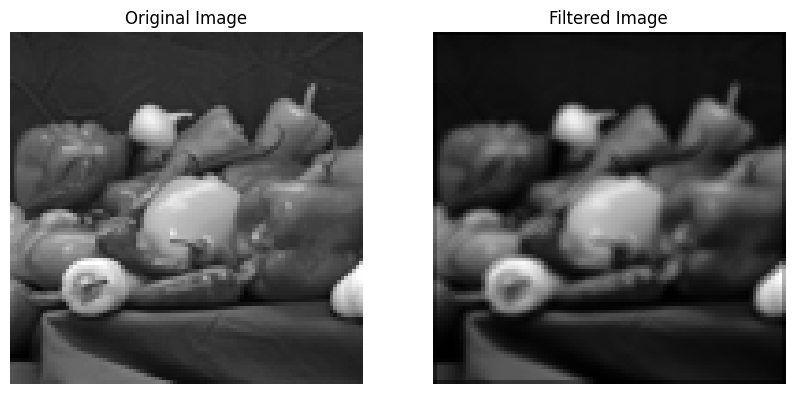

In [ ]:
# Plot original and filtered images
row, col = int(np.sqrt(X.shape[0])), int(np.sqrt(X.shape[0]))
original_image = X.view(row, col).detach().numpy()
filtered_image = output.view(row, col).detach().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Filtered Image")
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.show()